### Image Data Augmentation
# **Basic Image Manipulations**


In [1]:
import cv2
import numpy as np
import os, glob
import random
import time
import csv

from geometric_transformations import *

In [2]:
import matplotlib.pyplot as plt 
%matplotlib inline

In [28]:
ground_value = 6
road_value = 7
sidewalk_value = 8

person_value = 24


dataset_size = 17

### **Data path list creating**

### Paths in csv. file reading
#### ! First variant !

In [5]:
fgPaths = '/home/admin1/Programming/HIWI_MRT/image_data_augmentation/basic_approaches/citysc_fgPaths.csv'
bgPaths = '/home/admin1/Programming/HIWI_MRT/image_data_augmentation/basic_approaches/citysc_bgPaths.csv'

save_directory = '/home/admin1/Programming/HIWI_MRT/cityscapes_data/created_dataset/'

In [6]:
def pathReader(path):
    # Read paths of a CSV file
    with open(path, newline='') as fg_bg_data:
        reader = csv.reader(fg_bg_data)
        data = list(reader)
    return data

In [7]:
fg_path_list = pathReader(fgPaths)
bg_path_list = pathReader(bgPaths)

### Program testing
#### ! Second variante !

In [18]:
fg_dir = '/home/admin1/Programming/HIWI_MRT/cityscapes_data/foreground/'
bg_dir = '/home/admin1/Programming/HIWI_MRT/cityscapes_data/background/'

save_directory = '/home/admin1/Programming/HIWI_MRT/cityscapes_data/created_dataset/'

In [19]:
fg_path_list = [[fg_dir+'img'+'/aachen_000020_000019_leftImg8bit.png', fg_dir+'mask'+'/aachen_000020_000019_gtFine_labelIds.png'],
               [fg_dir+'img'+'/aachen_000031_000019_leftImg8bit.png', fg_dir+'mask'+'/aachen_000031_000019_gtFine_labelIds.png'],
               [fg_dir+'img'+'/aachen_000114_000019_leftImg8bit.png', fg_dir+'mask'+'/aachen_000114_000019_gtFine_labelIds.png'],
               [fg_dir+'img'+'/cologne_000056_000019_leftImg8bit.png', fg_dir+'mask'+'/cologne_000056_000019_gtFine_labelIds.png'],
               [fg_dir+'img'+'/cologne_000100_000019_leftImg8bit.png', fg_dir+'mask'+'/cologne_000100_000019_gtFine_labelIds.png'],
               [fg_dir+'img'+'/cologne_000108_000019_leftImg8bit.png', fg_dir+'mask'+'/cologne_000108_000019_gtFine_labelIds.png'],
               [fg_dir+'img'+'/cologne_000121_000019_leftImg8bit.png', fg_dir+'mask'+'/cologne_000121_000019_gtFine_labelIds.png']]

In [20]:
bg_path_list = [[bg_dir+'img'+'/bremen_000000_000019_leftImg8bit.png', bg_dir+'mask'+'/bremen_000000_000019_gtFine_labelIds.png'],
               [bg_dir+'img'+'/bremen_000001_000019_leftImg8bit.png', bg_dir+'mask'+'/bremen_000001_000019_gtFine_labelIds.png'],
               [bg_dir+'img'+'/bremen_000009_000019_leftImg8bit.png', bg_dir+'mask'+'/bremen_000009_000019_gtFine_labelIds.png']]

### **Basic image edit functions**

In [21]:
def data_name_choser(fg_path,bg_path): 
    FGname = '_'.join(fg_path[1].split('/')[-1].split('_')[:-2])
    BGname = '_'.join(bg_path[1].split('/')[-1].split('_')[:-2])
    
    return FGname, BGname

In [22]:
def data_loader(fg_path,bg_path):    
    # Foreground paths
    imgFG_path = fg_path[0]; maskFG_path = fg_path[1]
    
    # Background paths
    imgBG_path = bg_path[0]; maskBG_path = bg_path[1]
    
    
    FGimg = cv2.imread(imgFG_path); FGimg = cv2.cvtColor(FGimg, cv2.COLOR_BGR2RGB)
    FGmask = cv2.imread(maskFG_path); FGmask = cv2.cvtColor(FGmask, cv2.COLOR_BGR2RGB)
    
    BGimg = cv2.imread(imgBG_path); BGimg = cv2.cvtColor(BGimg, cv2.COLOR_BGR2RGB)
    BGmask = cv2.imread(maskBG_path); BGmask = cv2.cvtColor(BGmask, cv2.COLOR_BGR2RGB)
    
    return FGimg, FGmask, BGimg, BGmask     

In [23]:
def fg_bg_apply(preprocess_img, preprocess_mask, bg_img, bg_mask):   
    
    # applied_mask creating
    applied_mask = preprocess_mask.copy()
    applied_mask = np.where(applied_mask==255, person_value, bg_mask).astype(np.uint8)
    
    # applied_img creating
    mask = cv2.cvtColor(preprocess_mask.copy(), cv2.COLOR_BGR2GRAY)
    img = preprocess_img.copy() 
    roi = bg_img.copy()
    
    #IMG
    mask_inv = cv2.bitwise_not(mask)
    img_obj_fg = cv2.bitwise_and(img, img, mask=mask)
    
    #BG
    img_obj_bg = cv2.bitwise_and(roi, roi, mask=mask_inv)

    applied_img = cv2.add(img_obj_bg, img_obj_fg)
    applied_img = cv2.cvtColor(applied_img, cv2.COLOR_RGB2BGR)
    
    return applied_img, applied_mask

In [24]:
def data_saver(data_name, img, mask, id_data):
    img_path = os.path.join(save_directory, 'img', data_name + '_' + str(id_data) + '.jpg')
    mask_path = os.path.join(save_directory, 'mask', data_name + '_' + str(id_data) +'.png')
    
    cv2.imwrite(img_path, img)
    cv2.imwrite(mask_path, mask)

In [25]:
def current_id():
    path_list = glob.glob(os.path.join(save_directory, 'mask','*'))
    
    if not path_list:
        current_id = 1
    else:
        current_id = int(len(path_list)+1)
    return current_id

In [26]:
def gaussian_blur(img, mask):
    mask = np.where(mask==person_value, 255, 0).astype(np.uint8)
    mask = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)
    
    kernel = np.ones((3,3), np.uint8)
    mask_erosion = cv2.erode(mask, kernel, iterations=3) 
    mask_dilation = cv2.dilate(mask, kernel, iterations=3) 
    
    # Block No1
    summary_mask = cv2.subtract(mask_dilation,mask_erosion)
    gauss_img = cv2.GaussianBlur(img, (3, 3), 5)
    img_contour = cv2.bitwise_and(gauss_img, gauss_img, mask=summary_mask)
    
    # Block No2
    summary_mask_inv = cv2.bitwise_not(summary_mask)
    img_contour_inv = cv2.bitwise_and(img, img, mask=summary_mask_inv)
    
    # Summary
    summary_img = cv2.add(img_contour, img_contour_inv)
    
    return summary_img

## **Main function**

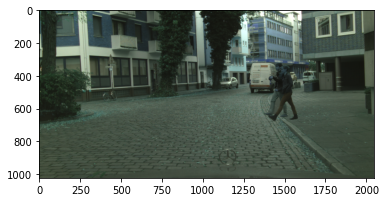

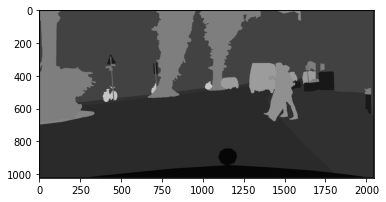

------------------- 13 done --------------------
------------------- 4 rest --------------------


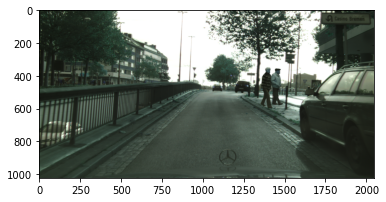

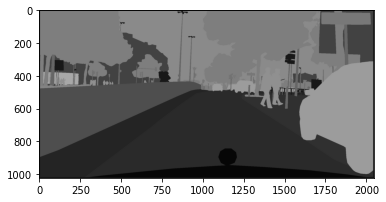

------------------- 14 done --------------------
------------------- 3 rest --------------------


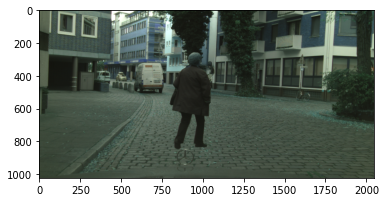

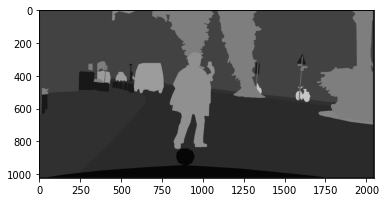

------------------- 15 done --------------------
------------------- 2 rest --------------------


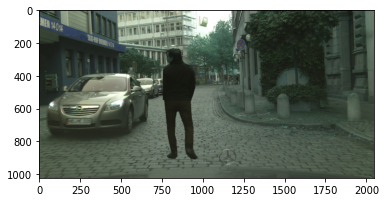

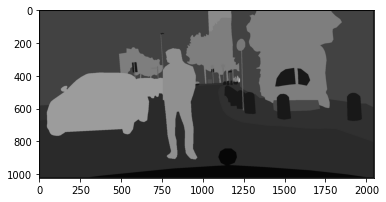

------------------- 16 done --------------------
------------------- 1 rest --------------------


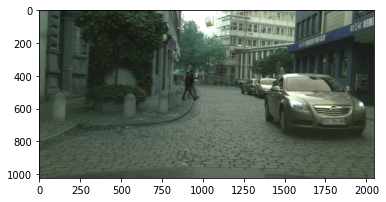

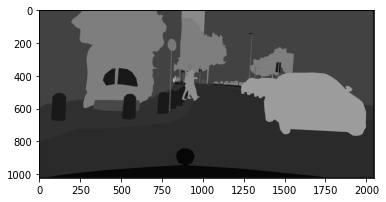

------------------- 17 done --------------------
------------------- 0 rest --------------------
----------------- 5.6 seconds ----------------


In [29]:
# MAIN
if __name__ == '__main__':
    start_time = time.time()

    id_data = current_id()
    #id_data = 1
    
    while  (id_data <= dataset_size):
        
        fg_path = random.choice(fg_path_list);  
        bg_path = random.choice(bg_path_list);

        # Data name chosing
        FGname,BGname = data_name_choser(fg_path, bg_path)

        # Data loading
        FGimg, FGmask, BGimg, BGmask = data_loader(fg_path, bg_path)
        FGheight = FGmask.shape[0]; FGwidth = FGmask.shape[1]
        BGheight = BGmask.shape[0]; BGwidth = BGmask.shape[1]

        
        # -------- Transformation/ Translation -------- #
        # Foreground fliping
        FGimg, FGmask = data_fliper(FGimg, FGmask)
        
        # Background fliping
        augment_BGimg, augment_BGmask = data_fliper(BGimg, BGmask)

        # Obj preprocessing 
        if obj_preprocesser(FGimg, FGmask, BGheight, BGwidth, person_value, FGheight, FGwidth):
            obj_img, obj_mask, x,y,w,h = obj_preprocesser(FGimg, FGmask, BGheight, BGwidth, person_value, FGheight, FGwidth)
        else:
            continue
            
        # Random place finding
        stand_y, stand_x, min_y = random_place_finder(augment_BGmask, ground_value, sidewalk_value, road_value, BGheight, BGwidth)

        # Size of person finding
        stand_obj_height, stand_obj_width = person_size_finder(stand_y, w, h)

        # Img and mask of object resizing 
        resized_obj_img, resized_obj_mask = obj_resizer(obj_img, obj_mask, stand_obj_height, stand_obj_width, person_value)

        # Foreground and background preprocessing 
        fg_bg_img, fg_bg_mask = fg_bg_preprocesser(resized_obj_img, resized_obj_mask, augment_BGimg, stand_y, stand_x, stand_obj_height, stand_obj_width, BGheight, BGwidth)

        
        # ------------------------------------- #
        # Foreground and background applying 
        applied_img, applied_mask = fg_bg_apply(fg_bg_img, fg_bg_mask, augment_BGimg, augment_BGmask)

        # Gaussian Blur
        applied_img = gaussian_blur(applied_img, applied_mask)

        # Data saving 
        data_saver(FGname, applied_img, applied_mask, id_data)

        plt.imshow(applied_img)
        plt.show()
        plt.imshow(applied_mask*6)
        plt.show()
        

        print("------------------- %s done --------------------" % (id_data))
        print("------------------- %s rest --------------------" % (dataset_size - id_data))
        id_data += 1
    print("----------------- %s seconds ----------------" % ( round((time.time() - start_time), 2) ))